# Prediction by Diagnosis Codes
In this notebook we use some fancier networks. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os, sys

%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K

Using TensorFlow backend.


In [5]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import Mat_reg, core_dtypes_pd

In [6]:
from ccs_tools import dx_multi, pr_multi

## Data Preparation

In [7]:
train_df = pd.read_csv(path+'cohorts/ami/DX_train.csv', dtype=core_dtypes_pd)
tst_df = pd.read_csv(path+'cohorts/ami/DX_tst.csv', dtype=core_dtypes_pd)

In [8]:
train_df.shape

(163671, 150)

In [9]:
all_df = pd.concat([train_df, tst_df])

Define the dictionaries for DX, DX1 and hosp, from value to int. 

In [58]:
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)
code_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE) + sorted(pr_multi.ICD9CM_CODE)
n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)
n_code_cat = len(code_cat)

DX_dict = dict(zip(DX_cat, range(len(DX_cat))))

PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat), len(DX_cat)+len(PR_cat)))))

n_DX = 30
n_PR = 15
DXs = ['DX'+str(j) for j in range(2, n_DX+1)]
PRs = ['PR'+str(j) for j in range(1, n_PR+1)]

In [12]:
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

In [13]:
hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories

hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

## Further Predictors

### Data Formatting

In [60]:
trn_df, val_df = train_test_split(train_df, test_size=0.11, stratify=train_df.HOSP_NRD)
N_trn = len(trn_df)
N_val = len(val_df)
train_df = pd.concat([trn_df, val_df])

In [61]:
DX_df = train_df[DXs]

DX_df = DX_df.fillna('missing')
DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
#DX_df[DX_df.isin(rare_code)] = 'missing'
DX_df[DX_df.isin(unclassified)] = 'missing'

for dx in DXs:
    DX_df[dx] = DX_df[dx].map(DX_dict)

DX_mat = DX_df.values

DX_mat.sort(axis=1)
#DX_mat = DX_mat[:, ::-1]

DX_mat_trn = DX_mat[:N_trn, ]
DX_mat_val = DX_mat[N_trn:, ]

In [62]:
PR_df = train_df[PRs]

PR_df = PR_df.fillna('missing')
PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
#PR_df[PR_df.isin(pr_rare_code)] = 'missing'

for pr in PRs:
    PR_df[pr] = PR_df[pr].map(PR_dict)

PR_mat = PR_df.values

PR_mat.sort(axis=1)
#DX_mat = DX_mat[:, ::-1]

PR_mat_trn = PR_mat[:N_trn, ]
PR_mat_val = PR_mat[N_trn:, ]

In [63]:
hosp_series = train_df['HOSP_NRD'].map(hosp_dict)
hosp_array = hosp_series.values

hosp_array_trn = hosp_array[:N_trn]
hosp_array_val = hosp_array[N_trn:]

In [64]:
demo_mat = train_df[['AGE', 'FEMALE']].values

age_mean = train_df['AGE'].mean()
age_std = train_df['AGE'].std()

demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std

In [65]:
DX1_series = train_df['DX1'].map(DX_dict)
DX1_array = DX1_series.values

DX1_array_trn = DX1_array[:N_trn]
DX1_array_val = DX1_array[N_trn:]

In [66]:
pay1_mat = to_categorical(train_df.PAY1.values)[:, 1:]

los_array = train_df.LOS.values
los_mean = np.mean(los_array)
los_std = np.std(los_array)
los_array = (los_array - los_mean)/los_std

ed_mat = to_categorical(train_df.HCUP_ED.values)

zipinc_mat = to_categorical(train_df.ZIPINC_QRTL.values)[:, 1:]

transfer_mat = to_categorical(train_df.SAMEDAYEVENT.values)

In [67]:
other_mat = np.concatenate((demo_mat, pay1_mat, los_array.reshape(los_array.shape+(1,)), ed_mat, zipinc_mat, 
                            transfer_mat), axis=1)
other_mat_trn = other_mat[:N_trn, ]
other_mat_val = other_mat[N_trn:, ]

In [68]:
y = train_df['readm30'].values.astype(int)

Y_trn = to_categorical(y[:N_trn])
Y_val = to_categorical(y[N_trn:])

## Model Building

In [24]:
from setsum_layer import SetSum, MaskedSum, MaskedDense

In [69]:
DX_embed_dim = 100
PR_embed_dim = 100
hosp_embed_dim = 1
#DX1_embed_dim = 1

In [26]:
embed_glove = np.load(path+'all/embed_mat0816.npy')

In [27]:
embed_glove.shape

(19021, 100)

In [30]:
n_code_cat

19021

In [70]:
input_DX1 = Input(shape=(1,))
DX1_embed = Embedding(input_dim=n_code_cat, output_dim=DX_embed_dim, embeddings_initializer=Constant(embed_glove), 
                     name='DX1_embed')(input_DX1)
DX1_embed = Reshape((DX_embed_dim,))(DX1_embed)

input_DX = Input(shape = (n_DX-1,))
DX_embed = Embedding(input_dim=n_code_cat, output_dim=DX_embed_dim, mask_zero=True, embeddings_initializer=Constant(embed_glove), 
                     name='DX_embed')(input_DX)

DX_feature = MaskedDense(DX_embed_dim, activation='relu')(DX_embed)
#DX_feature = MaskedDense(DX_embed_dim, activation='relu')(DX_feature)
DX_feature = MaskedSum()(DX_feature)

input_PR = Input(shape = (n_PR,))
PR_embed = Embedding(input_dim=n_code_cat, output_dim=PR_embed_dim, mask_zero=True, embeddings_initializer=Constant(embed_glove),
                     name='PR_embed')(input_PR)

PR_feature = MaskedDense(PR_embed_dim, activation='relu')(PR_embed)
PR_feature = MaskedSum()(PR_feature)

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

input_other = Input(shape=(other_mat.shape[1], ))

merged = Concatenate(axis=1)([DX1_embed, DX_feature, PR_feature, hosp_embed, input_other])

x = Dense(64, activation='relu')(merged)
#x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other], outputs=prediction)

In [71]:
for l in model.layers:
    if l.name=='DX_embed' or l.name=='PR_embed' or l.name=='DX1_embed':
        l.trainable = False

In [72]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [73]:
checkpoint = ModelCheckpoint(filepath=model_path+'ami_glove_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_glove_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=30)

In [74]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [75]:
hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_array_trn, other_mat_trn], Y_trn, 
                 batch_size=128, epochs=40, callbacks=[checkpoint, auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val], Y_val], 
                verbose=1)

Train on 145667 samples, validate on 18004 samples
Epoch 1/40
145667/145667 [==============================] - 5s 35us/step - loss: 1.3778 - val_loss: 0.6684
AUC: 0.6961

Epoch 2/40
145667/145667 [==============================] - 4s 31us/step - loss: 1.2638 - val_loss: 0.6196
AUC: 0.7031

Epoch 3/40
145667/145667 [==============================] - 4s 31us/step - loss: 1.2563 - val_loss: 0.6040
AUC: 0.7065

Epoch 4/40
145667/145667 [==============================] - 4s 31us/step - loss: 1.2502 - val_loss: 0.5824
AUC: 0.7090

Epoch 5/40
145667/145667 [==============================] - 4s 31us/step - loss: 1.2451 - val_loss: 0.6416
AUC: 0.7085

Epoch 6/40
145667/145667 [==============================] - 4s 30us/step - loss: 1.2425 - val_loss: 0.6166
AUC: 0.7115

Epoch 7/40
145667/145667 [==============================] - 5s 32us/step - loss: 1.2380 - val_loss: 0.6265
AUC: 0.7133

Epoch 8/40
145667/145667 [==============================] - 5s 31us/step - loss: 1.2359 - val_loss: 0.5882
AU

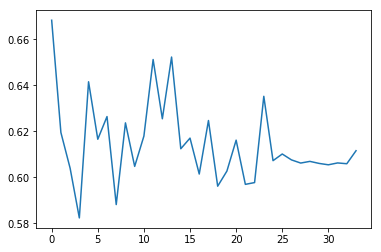

In [76]:
plt.plot(hist.history['val_loss'])

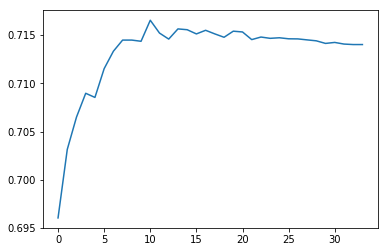

In [77]:
plt.plot(auccheckpoint.auc_history)

In [78]:
DX1_array_tst = tst_df.DX1.map(DX_dict).values

In [79]:
DX_df_tst = tst_df[DXs]
DX_df_tst = DX_df_tst.fillna('missing')
DX_df_tst[DX_df_tst.isin(['invl', 'incn'])]
#DX_df_tst[DX_df_tst.isin(rare_code)] = 'missing'
DX_df_tst[DX_df_tst.isin(unclassified)] = 'missing'

for dx in DXs:
    DX_df_tst[dx] = DX_df_tst[dx].map(DX_dict)

DX_mat_tst = DX_df_tst.values

DX_mat_tst.sort(axis=1)
#DX_mat_tst = DX_mat_tst[:, ::-1]

In [80]:
PR_df_tst = tst_df[PRs]
PR_df_tst = PR_df_tst.fillna('missing')
PR_df_tst[PR_df_tst.isin(['invl', 'incn'])] = 'missing'
#PR_df_tst[PR_df_tst.isin(pr_rare_code)] = 'missing'

for pr in PRs:
    PR_df_tst[pr] = PR_df_tst[pr].map(PR_dict)

PR_mat_tst = PR_df_tst.values
PR_mat_tst.sort(axis=1)

In [81]:
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std

In [82]:
hosp_array_tst = tst_df['HOSP_NRD'].map(hosp_dict).values

In [83]:
pay1_mat_tst = to_categorical(tst_df.PAY1.values)[:, 1:]

los_array_tst = (tst_df.LOS.values - los_mean)/los_std

ed_mat_tst = to_categorical(tst_df.HCUP_ED.values)

zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values)[:, 1:]

transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)

In [84]:
other_mat_tst = np.concatenate((demo_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst, transfer_mat_tst), axis=1)

In [85]:
model.load_weights(model_path+'ami_glove_auc1.h5')

In [88]:
y = model.predict([DX1_array_tst, DX_mat_tst, PR_mat_tst, hosp_array_tst, other_mat_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

18186/18186 [==============================] - 1s 35us/step


{0: 0.716672059300175}

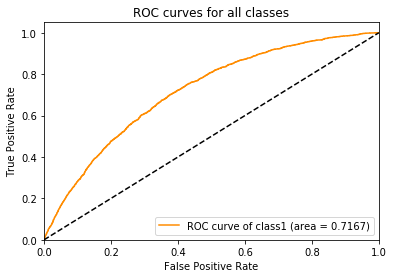

In [89]:
plot_roc(y_pred, y_true)

## Embedding Visualization

In [90]:
from sklearn import decomposition, manifold

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)

In [94]:
DX_embed_mat = embed_glove[1:n_DX_cat, ]
PR_embed_mat = embed_glove[n_DX_cat:, ]

In [97]:
embed_tsne = tsne.fit_transform(DX_embed_mat)

In [112]:
dx_multi = dx_multi.set_index(dx_multi.ICD9CM_CODE).drop(['ICD9CM_CODE'], axis=1)

In [120]:
ccs_lvl1 = [dx_multi.loc[c, 'CCS_LVL1']+'. '+dx_multi.loc[c, 'CCS_LVL1_LABEL'] for c in code_cat[1:n_DX_cat]]

In [ ]:
fine_group = [ami_ccs.loc[c, 'finest_non_empty'] for c in all_codes[1:(n_DX_cat-2)]]

In [122]:
plot_df = pd.DataFrame(dict(x=embed_tsne[:, 0], y=embed_tsne[:, 1], lvl1=ccs_lvl1))

In [80]:
plot_df = plot_df.assign(level=[len(g.split('.')) for g in plot_df.fine_group])

In [123]:
groups = plot_df.groupby('lvl1')

gkey = groups.groups.keys()

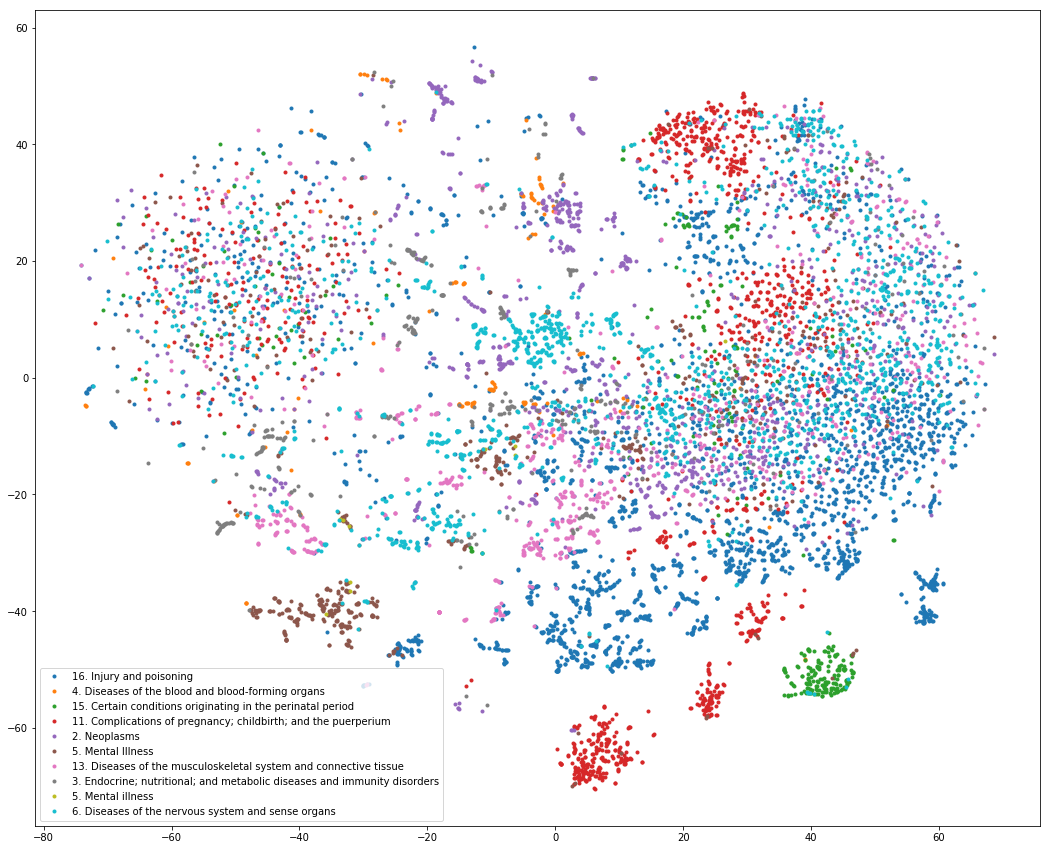

In [127]:
fig, ax = plt.subplots(figsize=(18, 15))
for name in list(gkey)[:10]:
    group = groups.get_group(name)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [130]:
PR_tsne = tsne.fit_transform(PR_embed_mat)

In [128]:
pr_multi = pr_multi.set_index(pr_multi.ICD9CM_CODE).drop(['ICD9CM_CODE'], axis=1)

In [129]:
pr_lvl1 = [pr_multi.loc[c, 'CCS_LVL1']+'. '+pr_multi.loc[c, 'CCS_LVL1_LABEL'] for c in code_cat[n_DX_cat:]]

In [ ]:
fine_group = [ami_ccs.loc[c, 'finest_non_empty'] for c in all_codes[1:(n_DX_cat-2)]]

In [131]:
plot_df = pd.DataFrame(dict(x=PR_tsne[:, 0], y=PR_tsne[:, 1], lvl1=pr_lvl1))

In [80]:
plot_df = plot_df.assign(level=[len(g.split('.')) for g in plot_df.fine_group])

In [132]:
groups = plot_df.groupby('lvl1')

gkey = groups.groups.keys()

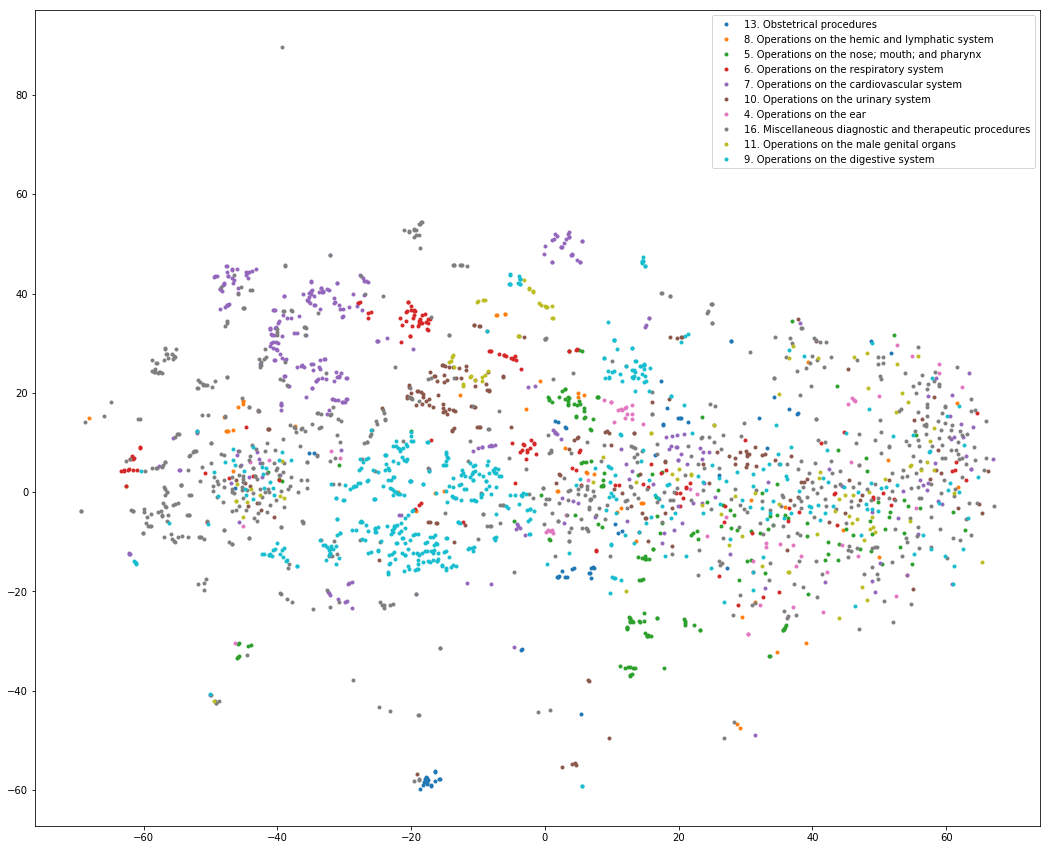

In [136]:
fig, ax = plt.subplots(figsize=(18, 15))
for name in list(gkey)[:10]:
    group = groups.get_group(name)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [83]:
top_fine_cat = ami_ccs.finest_non_empty.value_counts().iloc[:10].index

plot_subdf = plot_df.loc[plot_df.fine_group.isin(top_fine_cat)]

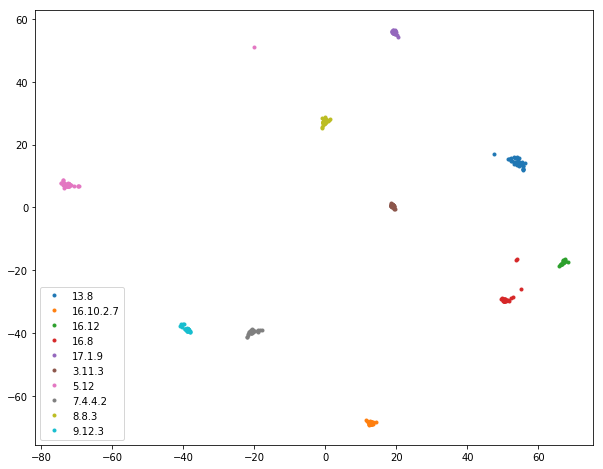

In [84]:
groups = plot_subdf.groupby('fine_group')

fig, ax = plt.subplots(figsize=(10, 8))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [153]:
plot_subdf = plot_df.loc[plot_df.lvl1=='3']

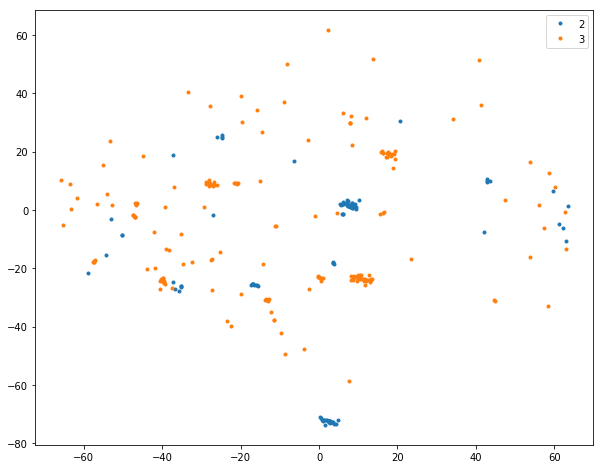

In [154]:
groups = plot_subdf.groupby('level')

fig, ax = plt.subplots(figsize=(10, 8))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [108]:
top_fine_cat

Index(['18', '13.8', '6.7.6', '16.12', '13.2.3', '16.8', '5.12', '6.9.1',
       '16.5', '2.16.2.5', '9.12.3', '16.10.2.7', '1.1.4', '9.2', '3.11.3',
       '3.4', '16.6.1', '17.1.9', '8.9', '10.1.8.3'],
      dtype='object')